# **Importing library&function**






In [99]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error, auc
from IPython.core.display import display, HTML
import numpy as np
import time
import os
from google.colab import drive
import itertools

!pip install split_folders
import splitfolders

!pip install scikit-learn

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
!ls /content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/
import splitfolders
import os
loc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/"
# csvloc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Result/"

gray_cataract  gray_diabetic_retinopathy  gray_glaucoma  gray_normal


In [102]:
import os
splitfolders.ratio(loc,output = "outputgrayscale",ratio = (0.70,0.15,0.15))
for dirpath,dirname,filename in os.walk("./outputgrayscale"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

Copying files: 4238 files [00:10, 414.76 files/s]

There are 3 directories and 0 images in './outputgrayscale'.
There are 4 directories and 0 images in './outputgrayscale/test'.
There are 0 directories and 158 images in './outputgrayscale/test/gray_cataract'.
There are 0 directories and 162 images in './outputgrayscale/test/gray_normal'.
There are 0 directories and 154 images in './outputgrayscale/test/gray_glaucoma'.
There are 0 directories and 166 images in './outputgrayscale/test/gray_diabetic_retinopathy'.
There are 4 directories and 0 images in './outputgrayscale/val'.
There are 0 directories and 209 images in './outputgrayscale/val/gray_cataract'.
There are 0 directories and 215 images in './outputgrayscale/val/gray_normal'.
There are 0 directories and 203 images in './outputgrayscale/val/gray_glaucoma'.
There are 0 directories and 219 images in './outputgrayscale/val/gray_diabetic_retinopathy'.
There are 4 directories and 0 images in './outputgrayscale/train'.
There are 0 directories and 838 images in './outputgrayscale/train/gr

In [103]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4,min_lr = 1e-7)

In [104]:
data_aug = tf.keras.Sequential([
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    # preprocessing.RandomRotation(0.2),
    # preprocessing.RandomFlip("horizontal")
],name = "data_augmentation_layer")

In [105]:
def predict_labels(model, X_test):
    return model.predict(X_test)

def display_classification_report(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

def calculate_specificity(y_test, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # specificity = tn / (tn + fp)
    # print(f"Specificity: {specificity}")
    cm = confusion_matrix(y_test, y_pred)
    specificity = []
    for i in range(cm.shape[0]):
      spec = cm[i, i] / (np.sum(cm[i, :]) - cm[i, i] + np.sum(cm[:, :]) - np.sum(cm[i, :]))
      specificity.append(spec)
    print(f"Specificity: {specificity}")

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize
    n_classes = cm.shape[0]  # find the number of classes

    specificity = []  # To store specificity values for each class

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
    )

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        specificity_val = (cm.sum() - cm[i].sum() - cm[:, j].sum() + cm[i, j]) / (
            cm.sum() - cm[:, j].sum()
        )
        specificity.append(specificity_val)

        if norm:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%,\n {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%, Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ( {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} (Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )

    if savefig:
        fig.savefig("confusion_matrix.png")

    return specificity

def calculate_mse(y_test, y_probs, n_classes):
  y_true_onehot = tf.keras.utils.to_categorical(y_test, n_classes)
  mse = mean_squared_error(y_true_onehot, y_probs)
  print(f"Mean Squared Error: : {mse}")
  return y_true_onehot

def calculate_roc_auc_score(y_test, y_probs):
  auc_roc = roc_auc_score(y_test, y_probs, multi_class='ovr', average=None)
  average_auc_roc = np.mean(auc_roc)
  print(f"The average AUC-ROC is {average_auc_roc}")

In [106]:
def sharpen_image(image, factor=1.5):
    adjusted = tf.image.adjust_contrast(image, factor)
    return adjusted

# **Batch size: 16**

In [107]:
epoch = 20
batchsize = 16

In [108]:
train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_classes = sorted([name for name in os.listdir(train_dir)])
# class_names = train_classes  # Assuming class names are the same across train, test, and val

# Load datasets
train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3389 files belonging to 4 classes.
Found 640 files belonging to 4 classes.
Found 846 files belonging to 4 classes.


In [109]:
class_names = train_data.class_names  # Store class names before transformations

# Apply transformations using map() function
train_data = train_data.map(lambda x, y: (sharpen_image(x), y))
test_data = test_data.map(lambda x, y: (sharpen_image(x), y))
val_data = val_data.map(lambda x, y: (sharpen_image(x), y))


# **EfficientNetV2B3 Model**

In [110]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [111]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_9  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_27 (Dense)            (None, 32)                49184     
                                                           

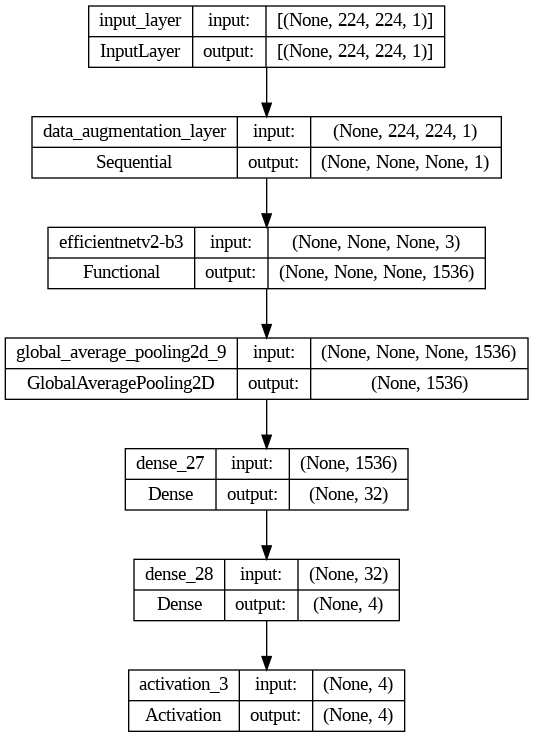

In [112]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [113]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [114]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 29s 82ms/step - loss: 0.6530 - accuracy: 0.7386 - val_loss: 0.5113 - val_accuracy: 0.8227 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 13s 63ms/step - loss: 0.4996 - accuracy: 0.8097 - val_loss: 0.4343 - val_accuracy: 0.8487 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 14s 64ms/step - loss: 0.4454 - accuracy: 0.8244 - val_loss: 0.4336 - val_accuracy: 0.8428 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 14s 65ms/step - loss: 0.4155 - accuracy: 0.8410 - val_loss: 0.3868 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 13s 63ms/step - loss: 0.4002 - accuracy: 0.8451 - val_loss: 0.3837 - val_accuracy: 0.8582 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 13s 63ms/step - loss: 0.3865 - accuracy: 0.8472 - val_loss: 0.3891 - val_accuracy: 0.8629 - lr: 0.0010
Epoch 7/20
212/212 [==============================] - 14s 

EfficientNetV2B3 Evaluation

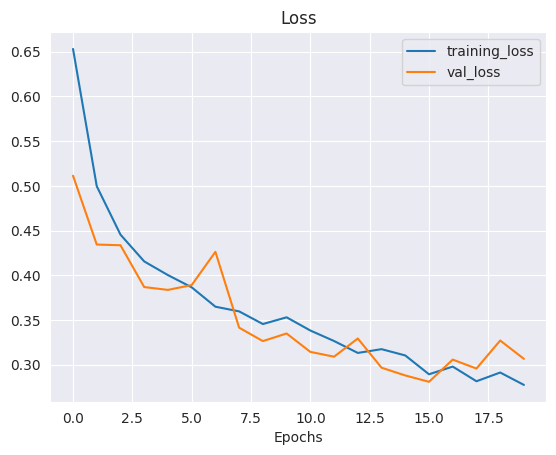

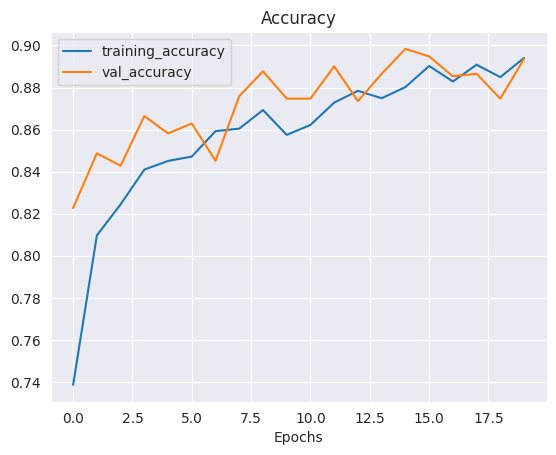

In [115]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 2s 43ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       158
           1       0.91      0.98      0.94       166
           2       0.88      0.68      0.77       154
           3       0.82      0.91      0.87       162

    accuracy                           0.88       640
   macro avg       0.88      0.87      0.87       640
weighted avg       0.88      0.88      0.87       640

Specificity: [0.29292929292929293, 0.3389121338912134, 0.19626168224299065, 0.3008130081300813]
Mean Squared Error: : 0.11477488279342651
The average AUC-ROC is 0.9754289448034841


[0.9727463312368972,
 0.658008658008658,
 0.7120921305182342,
 0.6673913043478261,
 0.6519916142557652,
 0.9913419913419913,
 0.6813819577735125,
 0.6478260869565218,
 0.7085953878406709,
 0.6904761904761905,
 0.9059500959692899,
 0.7152173913043478,
 0.6666666666666666,
 0.6601731601731602,
 0.7005758157389635,
 0.9695652173913043]

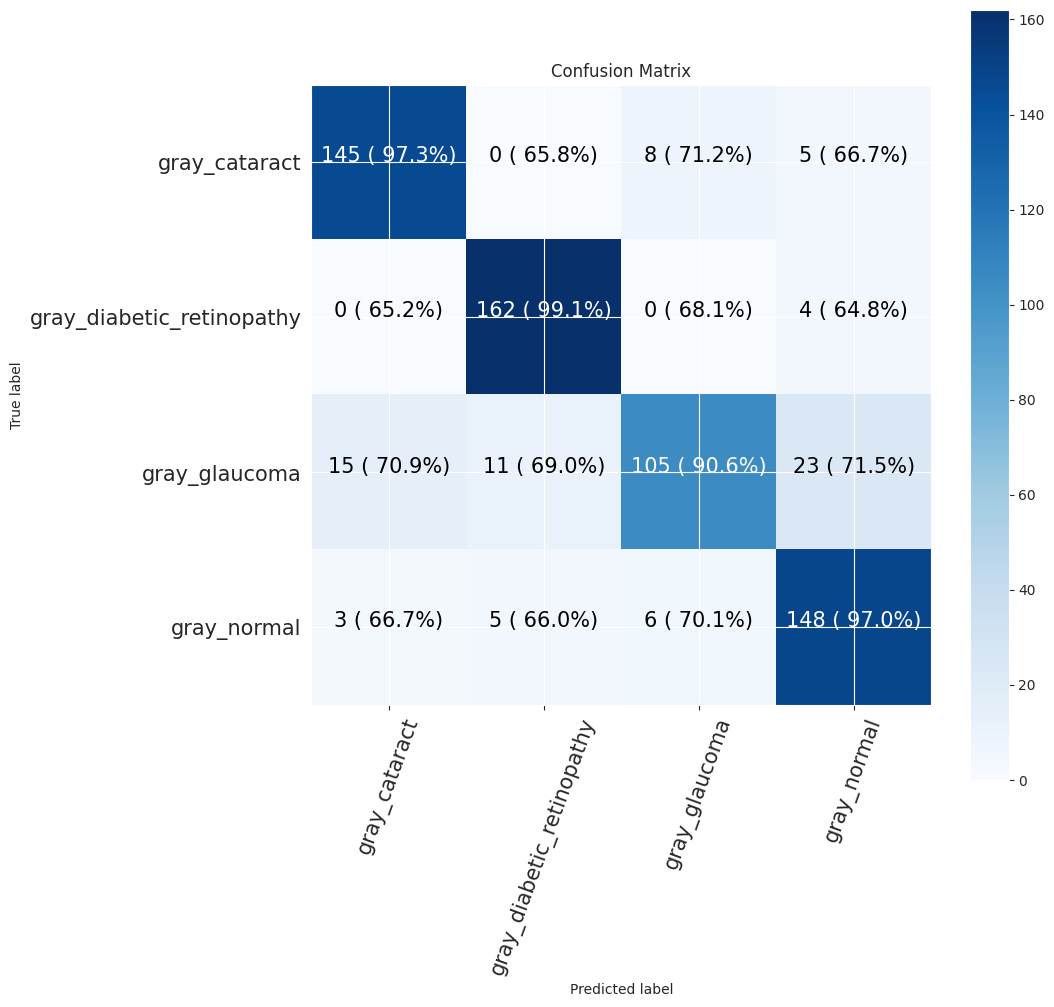

In [116]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


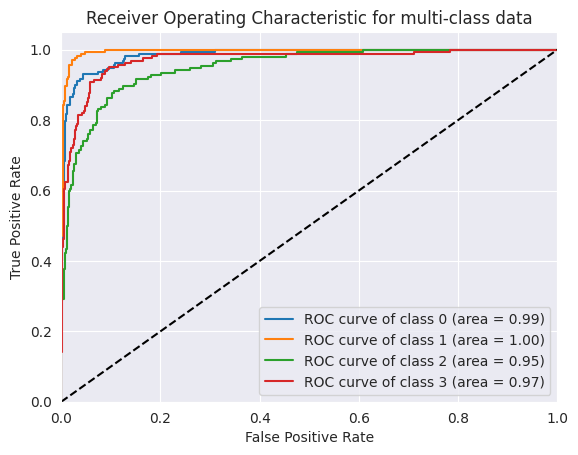

In [117]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [118]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 26, 26, 128)      

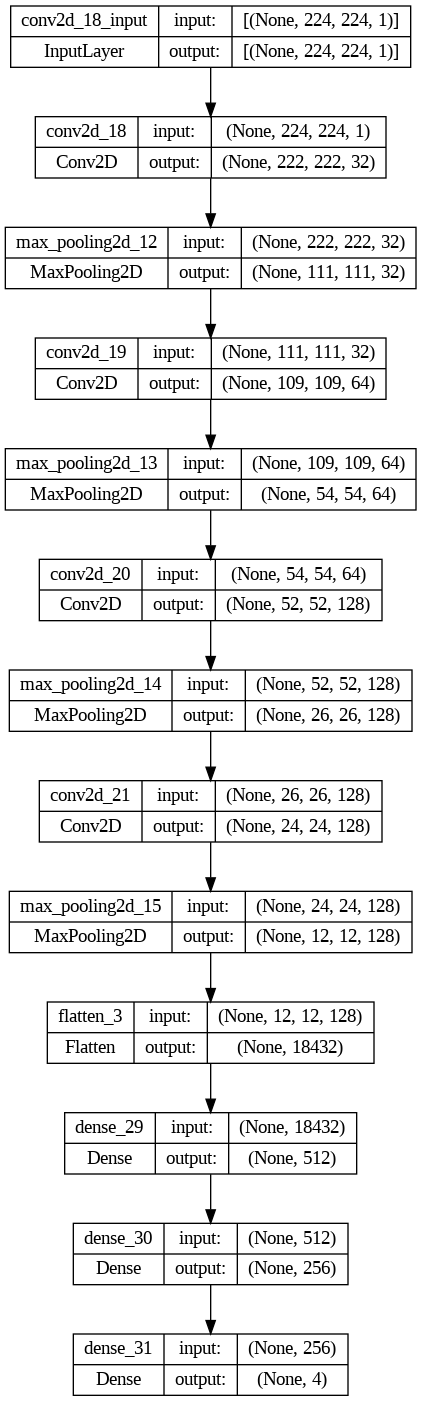

In [119]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [120]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [121]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 7s 25ms/step - loss: 1.9686 - accuracy: 0.5205 - val_loss: 0.8397 - val_accuracy: 0.6028 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 5s 23ms/step - loss: 0.7866 - accuracy: 0.6264 - val_loss: 0.7129 - val_accuracy: 0.6856 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 5s 23ms/step - loss: 0.6870 - accuracy: 0.6855 - val_loss: 0.6626 - val_accuracy: 0.6998 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 5s 23ms/step - loss: 0.6186 - accuracy: 0.7191 - val_loss: 0.5347 - val_accuracy: 0.7518 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 5s 23ms/step - loss: 0.6407 - accuracy: 0.7238 - val_loss: 0.7042 - val_accuracy: 0.7057 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 5s 23ms/step - loss: 0.7558 - accuracy: 0.6465 - val_loss: 0.9067 - val_accuracy: 0.6572 - lr: 0.0010
Epoch 7/20
212/212 [==============================] - 5s 23ms/st

CNN Evaluation

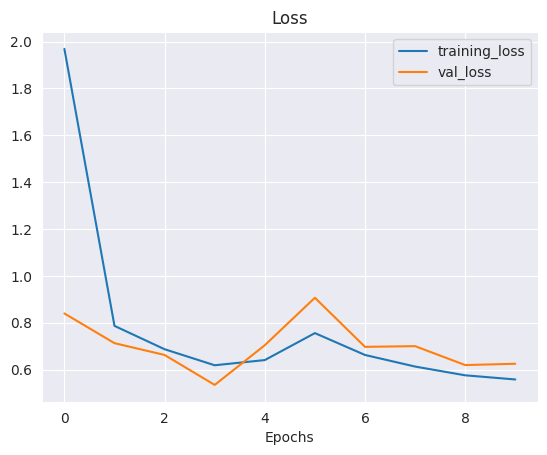

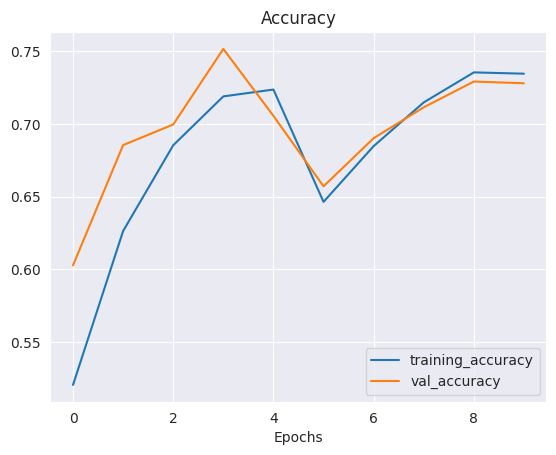

In [122]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 0s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.46      0.53       158
           1       0.99      0.99      0.99       166
           2       0.57      0.50      0.53       154
           3       0.66      0.90      0.76       162

    accuracy                           0.72       640
   macro avg       0.71      0.71      0.70       640
weighted avg       0.71      0.72      0.71       640

Specificity: [0.12874779541446207, 0.3473684210526316, 0.13676731793960922, 0.29554655870445345]
Mean Squared Error: : 0.1396797001361847
The average AUC-ROC is 0.8946981878429499


[0.836852207293666,
 0.6666666666666666,
 0.7762376237623763,
 0.719047619047619,
 0.6813819577735125,
 0.9978902953586498,
 0.6732673267326733,
 0.6047619047619047,
 0.7869481765834933,
 0.6751054852320675,
 0.8475247524752475,
 0.7142857142857143,
 0.6948176583493282,
 0.6603375527426161,
 0.7029702970297029,
 0.9619047619047619]

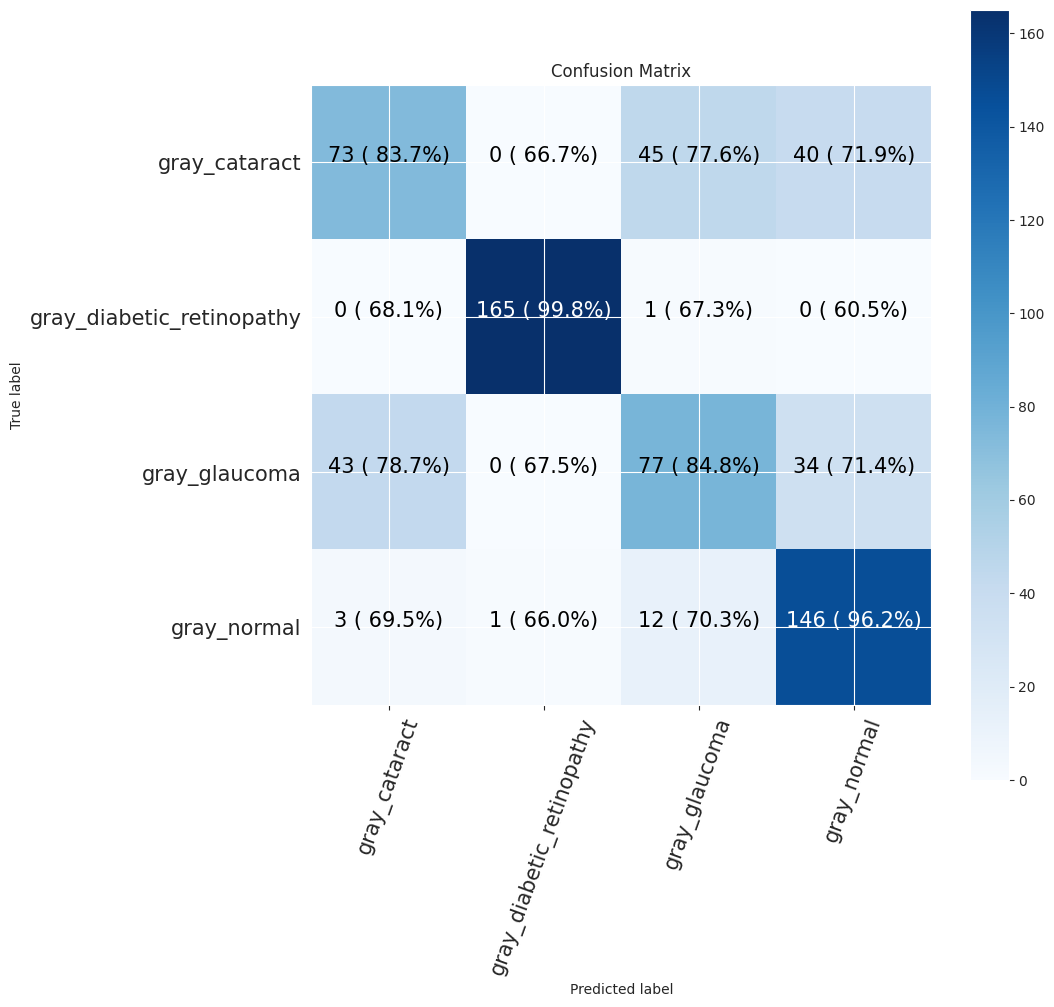

In [123]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


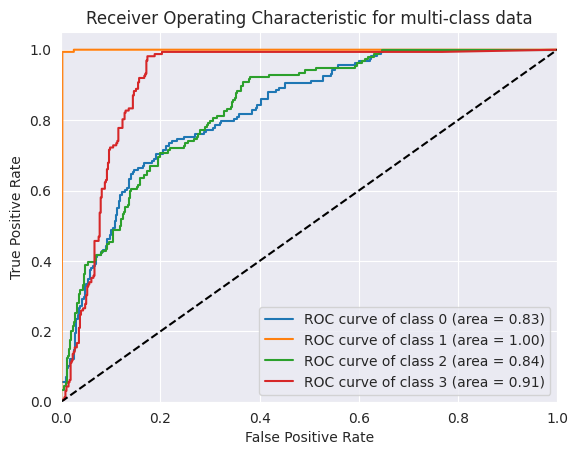

In [124]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [125]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_22 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_32 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_33 (Dense)            (None, 4)                 4100      
                                                          

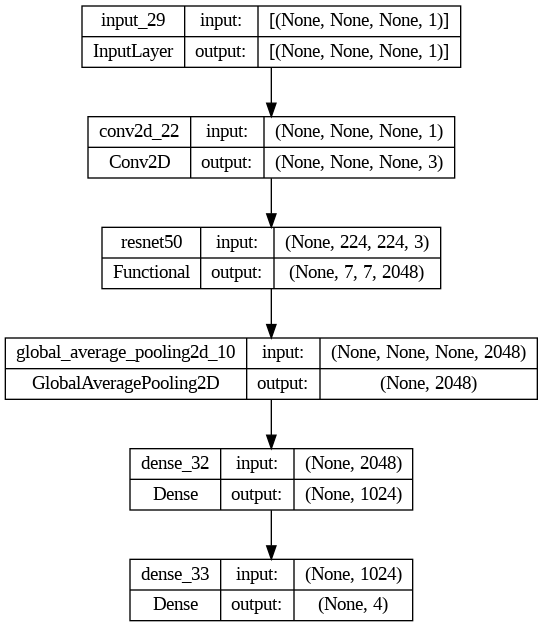

In [126]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [127]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [128]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 36s 152ms/step - loss: 0.6790 - accuracy: 0.7719 - val_loss: 0.4451 - val_accuracy: 0.8239 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 30s 142ms/step - loss: 0.3667 - accuracy: 0.8578 - val_loss: 0.2936 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 30s 141ms/step - loss: 0.3062 - accuracy: 0.8758 - val_loss: 0.2579 - val_accuracy: 0.8995 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 30s 141ms/step - loss: 0.2738 - accuracy: 0.8882 - val_loss: 0.2720 - val_accuracy: 0.8901 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 30s 141ms/step - loss: 0.2438 - accuracy: 0.9056 - val_loss: 0.3388 - val_accuracy: 0.8452 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 30s 141ms/step - loss: 0.2261 - accuracy: 0.9106 - val_loss: 0.2182 - val_accuracy: 0.9125 - lr: 0.0010
Epoch 7/20
212/212 [==============================] 

ResNet50 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 2s 48ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       158
           1       0.99      0.99      0.99       166
           2       0.83      0.84      0.83       154
           3       0.86      0.81      0.83       162

    accuracy                           0.89       640
   macro avg       0.89      0.89      0.89       640
weighted avg       0.89      0.89      0.89       640

Specificity: [0.29292929292929293, 0.3445378151260504, 0.25244618395303325, 0.25736738703339884]
Mean Squared Error: : 0.10782384127378464
The average AUC-ROC is 0.9853682495998449


[0.9725738396624473,
 0.6666666666666666,
 0.6838842975206612,
 0.6926229508196722,
 0.6518987341772152,
 0.9957805907172996,
 0.6570247933884298,
 0.6618852459016393,
 0.7025316455696202,
 0.6751054852320675,
 0.9483471074380165,
 0.7090163934426229,
 0.6729957805907173,
 0.6624472573839663,
 0.7107438016528925,
 0.9364754098360656]

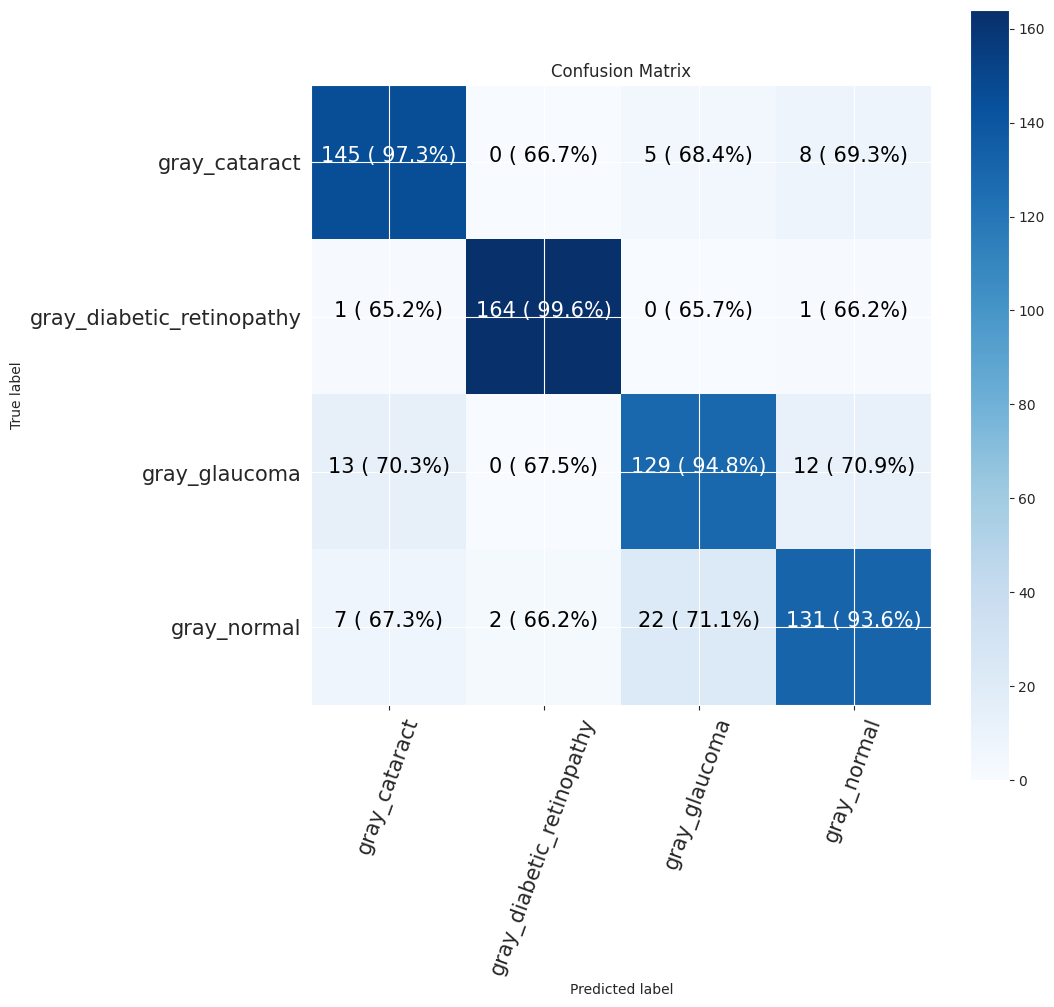

In [129]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


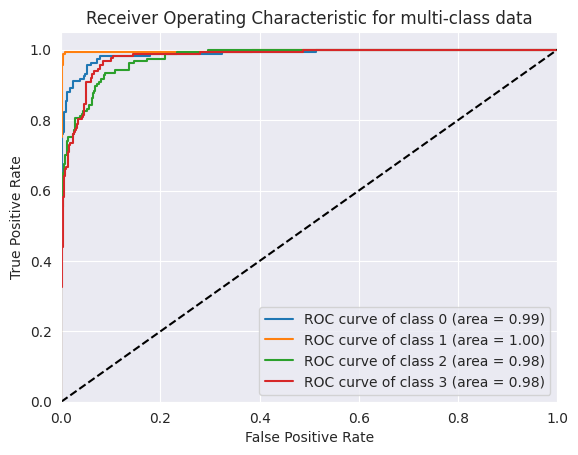

In [130]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [131]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_23 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 dense_34 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_35 (Dense)            (None, 4)                 4100      
                                                          

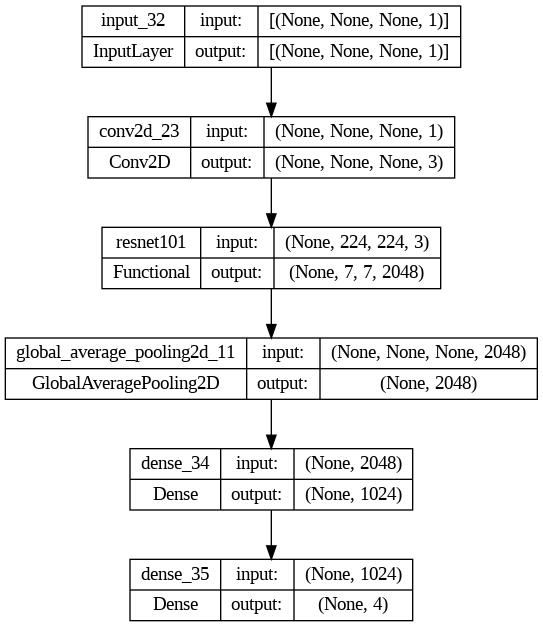

In [132]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [133]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [134]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
212/212 [==============================] - 59s 244ms/step - loss: 0.6387 - accuracy: 0.7704 - val_loss: 0.4637 - val_accuracy: 0.8191 - lr: 0.0010
Epoch 2/20
212/212 [==============================] - 49s 232ms/step - loss: 0.3759 - accuracy: 0.8531 - val_loss: 0.3649 - val_accuracy: 0.8664 - lr: 0.0010
Epoch 3/20
212/212 [==============================] - 50s 233ms/step - loss: 0.3100 - accuracy: 0.8767 - val_loss: 0.3157 - val_accuracy: 0.8723 - lr: 0.0010
Epoch 4/20
212/212 [==============================] - 49s 233ms/step - loss: 0.2975 - accuracy: 0.8840 - val_loss: 0.3567 - val_accuracy: 0.8534 - lr: 0.0010
Epoch 5/20
212/212 [==============================] - 49s 233ms/step - loss: 0.2624 - accuracy: 0.8964 - val_loss: 0.2952 - val_accuracy: 0.8877 - lr: 0.0010
Epoch 6/20
212/212 [==============================] - 49s 233ms/step - loss: 0.2355 - accuracy: 0.9094 - val_loss: 0.2406 - val_accuracy: 0.9078 - lr: 0.0010
Epoch 7/20
212/212 [==============================] 

ResNet101 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 3s 81ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       158
           1       0.98      0.99      0.98       166
           2       0.85      0.86      0.86       154
           3       0.88      0.87      0.88       162

    accuracy                           0.91       640
   macro avg       0.91      0.91      0.91       640
weighted avg       0.91      0.91      0.91       640

Specificity: [0.2903225806451613, 0.3445378151260504, 0.26232741617357, 0.28256513026052105]
Mean Squared Error: : 0.10628357529640198
The average AUC-ROC is 0.9836070021663904


[0.9710743801652892,
 0.6659619450317125,
 0.6873706004140787,
 0.6854166666666667,
 0.6590909090909091,
 0.9957716701902748,
 0.6583850931677019,
 0.6541666666666667,
 0.6983471074380165,
 0.6765327695560254,
 0.9565217391304348,
 0.7041666666666667,
 0.6714876033057852,
 0.6617336152219874,
 0.6977225672877847,
 0.95625]

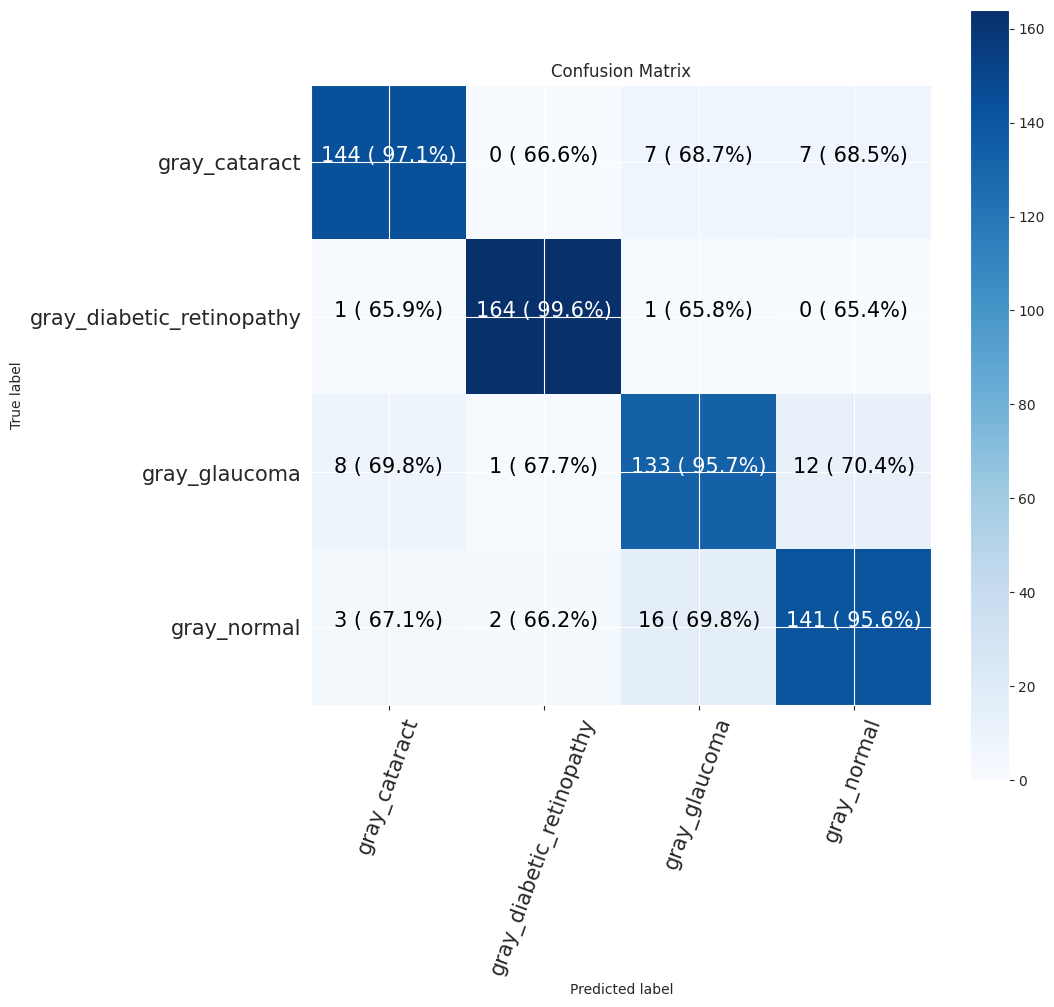

In [135]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


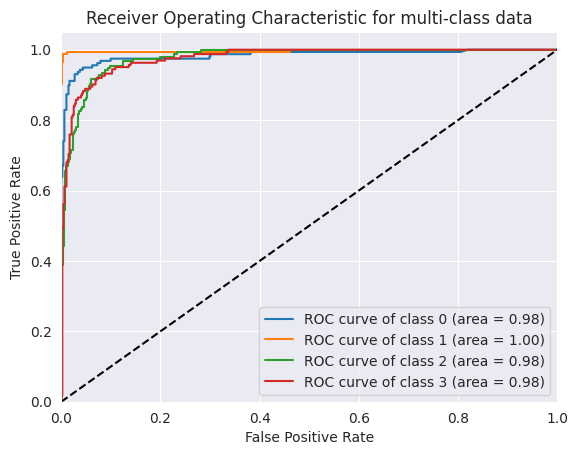

In [136]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 32**

In [137]:
epoch = 20
batchsize = 32

In [138]:
train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_classes = sorted([name for name in os.listdir(train_dir)])
# class_names = train_classes  # Assuming class names are the same across train, test, and val

# Load datasets
train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3389 files belonging to 4 classes.
Found 640 files belonging to 4 classes.
Found 846 files belonging to 4 classes.


In [139]:
class_names = train_data.class_names  # Store class names before transformations

# Apply transformations using map() function
train_data = train_data.map(lambda x, y: (sharpen_image(x), y))
test_data = test_data.map(lambda x, y: (sharpen_image(x), y))
val_data = val_data.map(lambda x, y: (sharpen_image(x), y))


# **EfficientNetV2B3 Model**

In [140]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [141]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 dense_36 (Dense)            (None, 32)                49184     
                                                          

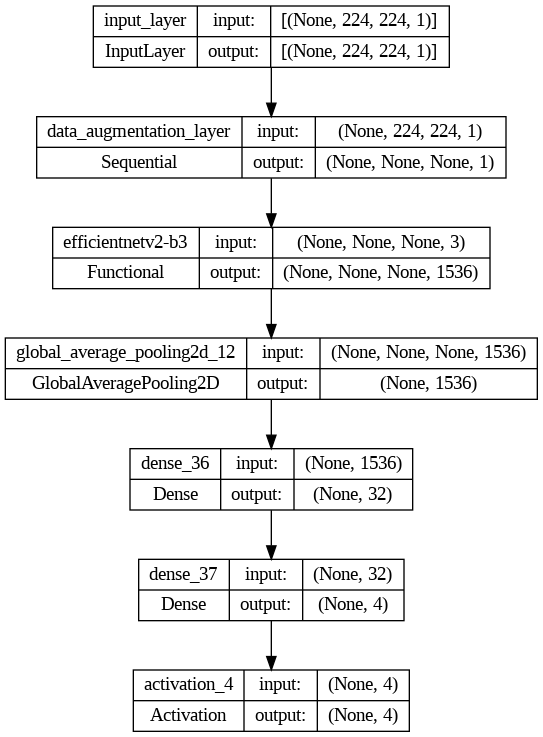

In [142]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [143]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [144]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 26s 137ms/step - loss: 0.7015 - accuracy: 0.7203 - val_loss: 0.5773 - val_accuracy: 0.7837 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 12s 115ms/step - loss: 0.5066 - accuracy: 0.8032 - val_loss: 0.5288 - val_accuracy: 0.8121 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 12s 117ms/step - loss: 0.4532 - accuracy: 0.8221 - val_loss: 0.4423 - val_accuracy: 0.8534 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 12s 114ms/step - loss: 0.4342 - accuracy: 0.8398 - val_loss: 0.4235 - val_accuracy: 0.8593 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 12s 114ms/step - loss: 0.4086 - accuracy: 0.8492 - val_loss: 0.4075 - val_accuracy: 0.8558 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 12s 115ms/step - loss: 0.3952 - accuracy: 0.8451 - val_loss: 0.4387 - val_accuracy: 0.8428 - lr: 0.0010
Epoch 7/20
106/106 [==============================] 

EfficientNetV2B3 Evaluation

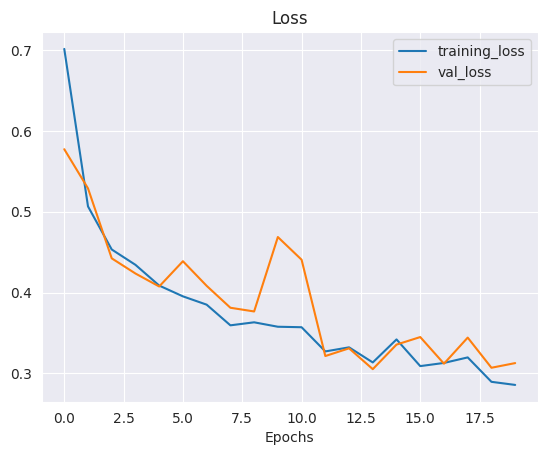

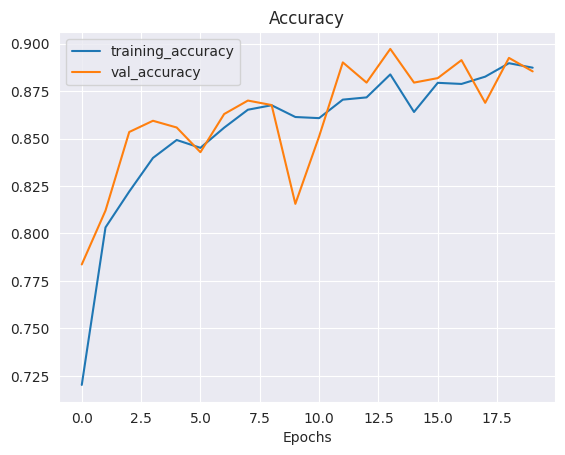

In [145]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 2s 77ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       158
           1       0.96      0.96      0.96       166
           2       0.88      0.69      0.77       154
           3       0.79      0.91      0.85       162

    accuracy                           0.87       640
   macro avg       0.87      0.87      0.87       640
weighted avg       0.88      0.87      0.87       640

Specificity: [0.29554655870445345, 0.3305613305613306, 0.19850187265917604, 0.29817444219066935]
Mean Squared Error: : 0.11545997858047485
The average AUC-ROC is 0.9758826805090208


[0.9745222929936306,
 0.6666666666666666,
 0.7076923076923077,
 0.6659340659340659,
 0.6496815286624203,
 0.9852320675105485,
 0.6807692307692308,
 0.6483516483516484,
 0.7133757961783439,
 0.6814345991561181,
 0.9076923076923077,
 0.7186813186813187,
 0.6624203821656051,
 0.6666666666666666,
 0.7038461538461539,
 0.967032967032967]

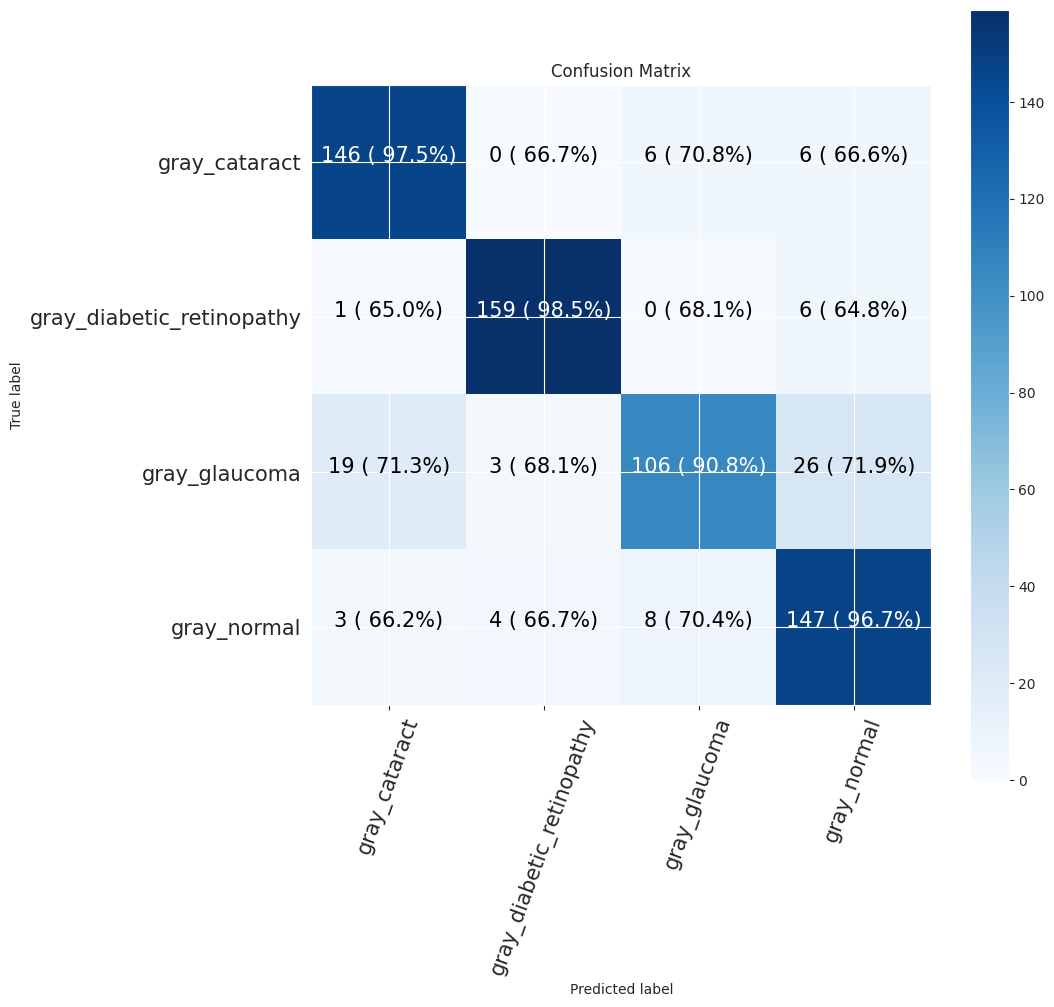

In [146]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


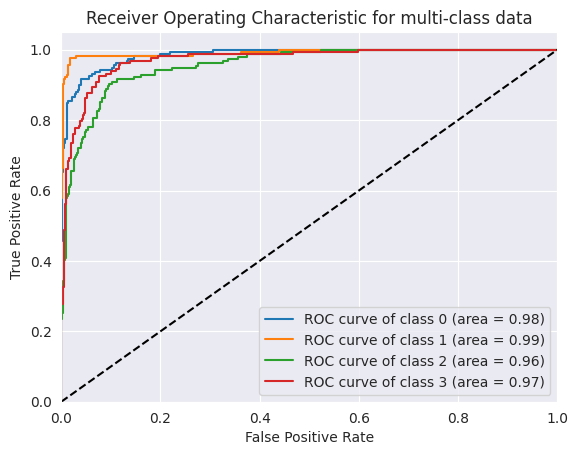

In [147]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [148]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 26, 26, 128)      

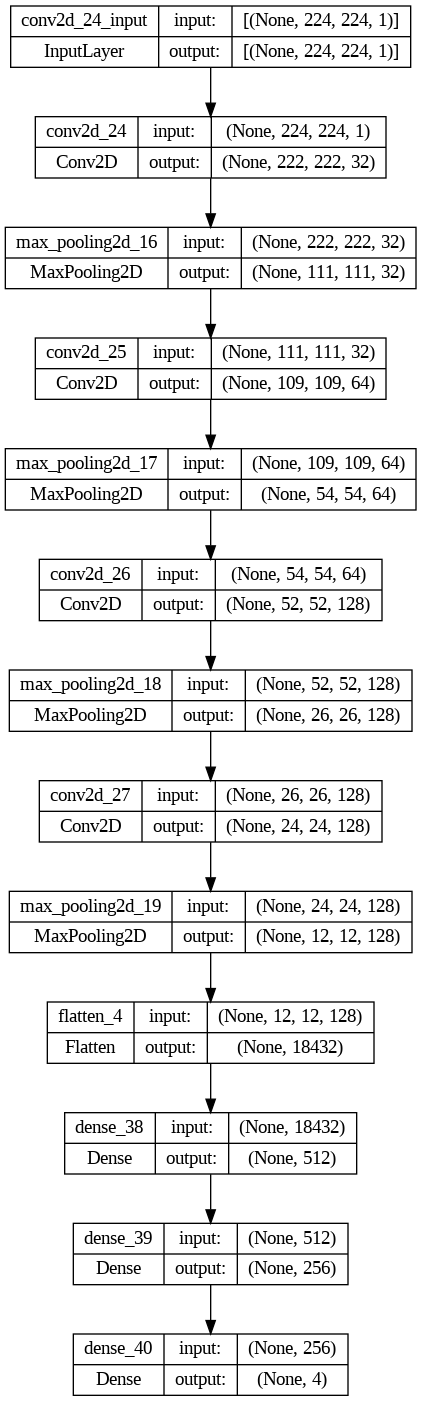

In [149]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [150]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [151]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 6s 39ms/step - loss: 3.9419 - accuracy: 0.5232 - val_loss: 1.0093 - val_accuracy: 0.5721 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 4s 37ms/step - loss: 0.8253 - accuracy: 0.6377 - val_loss: 0.5992 - val_accuracy: 0.7707 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 4s 37ms/step - loss: 0.6001 - accuracy: 0.7371 - val_loss: 0.5763 - val_accuracy: 0.7624 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 4s 37ms/step - loss: 0.5353 - accuracy: 0.7754 - val_loss: 0.5813 - val_accuracy: 0.7683 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 4s 37ms/step - loss: 0.4924 - accuracy: 0.7943 - val_loss: 0.4945 - val_accuracy: 0.8038 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 4s 37ms/step - loss: 0.4686 - accuracy: 0.8132 - val_loss: 0.4982 - val_accuracy: 0.8038 - lr: 0.0010
Epoch 7/20
106/106 [==============================] - 4s 37ms/st

CNN Evaluation

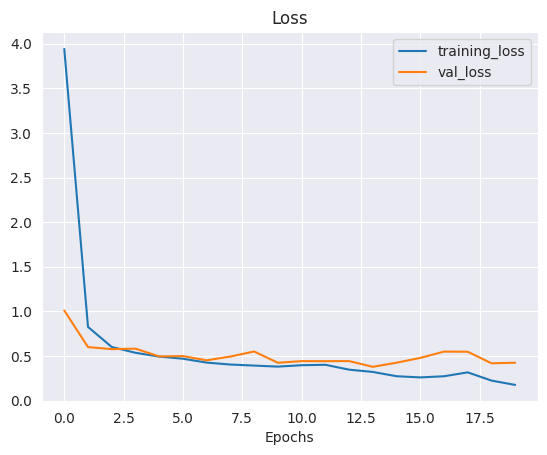

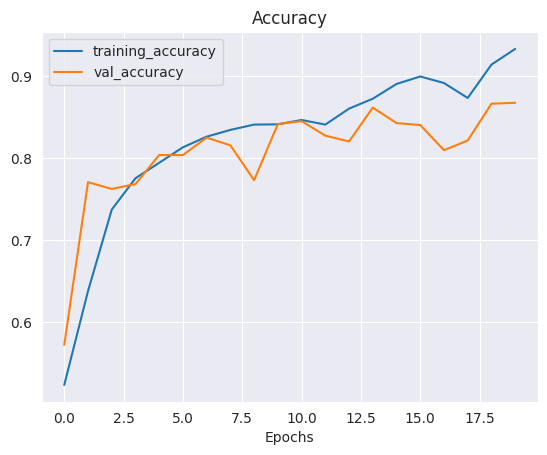

In [152]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 0s 13ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       158
           1       0.97      0.98      0.97       166
           2       0.68      0.69      0.69       154
           3       0.74      0.77      0.76       162

    accuracy                           0.80       640
   macro avg       0.80      0.80      0.80       640
weighted avg       0.80      0.80      0.80       640

Specificity: [0.2237093690248566, 0.3389121338912134, 0.20075046904315197, 0.24271844660194175]
Mean Squared Error: : 0.1240428239107132
The average AUC-ROC is 0.9411148288131369


[0.9168356997971603,
 0.6659619450317125,
 0.7184265010351967,
 0.7048832271762208,
 0.6632860040567952,
 0.9915433403805497,
 0.6583850931677019,
 0.6539278131634819,
 0.7342799188640974,
 0.678646934460888,
 0.9026915113871635,
 0.7197452229299363,
 0.6855983772819473,
 0.6638477801268499,
 0.7204968944099379,
 0.921443736730361]

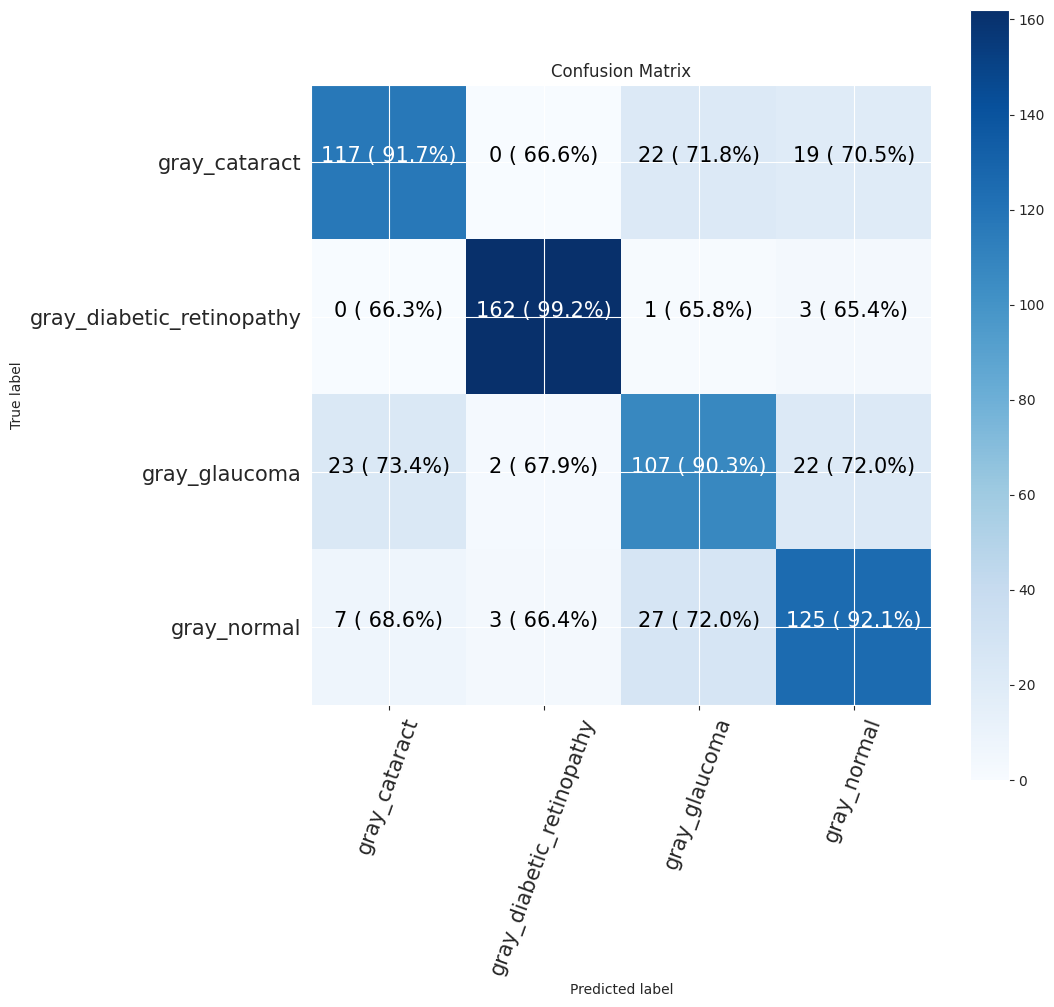

In [153]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


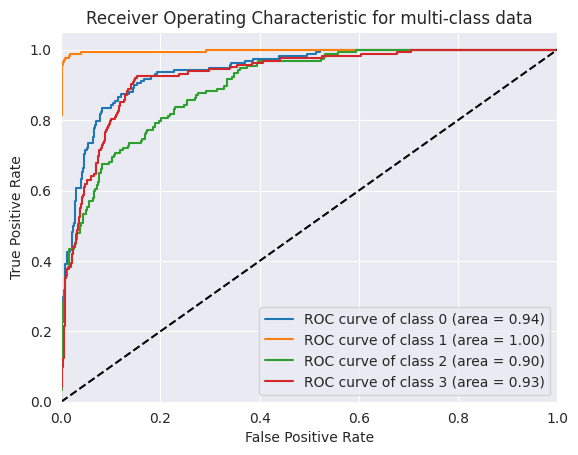

In [154]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [155]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_28 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 3 (GlobalAveragePooling2D)                                      
                                                                 
 dense_41 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_42 (Dense)            (None, 4)                 4100      
                                                          

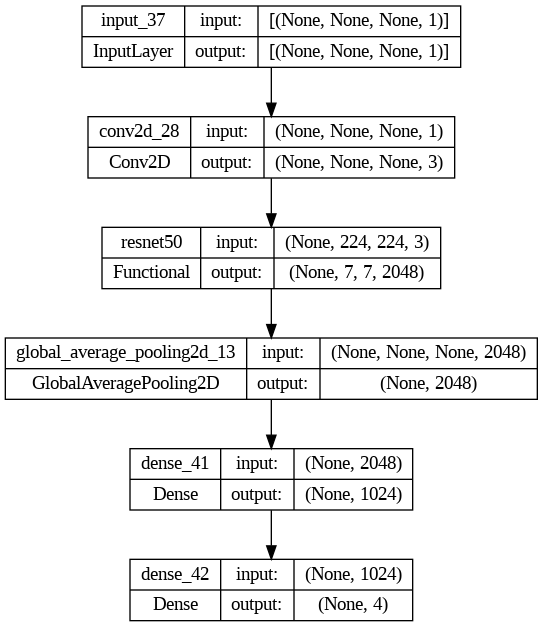

In [156]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [157]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [158]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 34s 278ms/step - loss: 0.6696 - accuracy: 0.7737 - val_loss: 0.4261 - val_accuracy: 0.8298 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 29s 269ms/step - loss: 0.3618 - accuracy: 0.8619 - val_loss: 0.3262 - val_accuracy: 0.8617 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 28s 267ms/step - loss: 0.3027 - accuracy: 0.8829 - val_loss: 0.3058 - val_accuracy: 0.8924 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 28s 267ms/step - loss: 0.2568 - accuracy: 0.9032 - val_loss: 0.2627 - val_accuracy: 0.8995 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 28s 267ms/step - loss: 0.2393 - accuracy: 0.9100 - val_loss: 0.2309 - val_accuracy: 0.9113 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 28s 267ms/step - loss: 0.1976 - accuracy: 0.9259 - val_loss: 0.2337 - val_accuracy: 0.9090 - lr: 0.0010
Epoch 7/20
106/106 [==============================] 

ResNet50 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 2s 90ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       158
           1       0.98      0.99      0.99       166
           2       0.80      0.84      0.82       154
           3       0.89      0.85      0.87       162

    accuracy                           0.89       640
   macro avg       0.89      0.89      0.89       640
weighted avg       0.89      0.89      0.89       640

Specificity: [0.28256513026052105, 0.3473684210526316, 0.25244618395303325, 0.27236580516898606]
Mean Squared Error: : 0.10841403901576996
The average AUC-ROC is 0.9850122612790391


[0.9648033126293996,
 0.6652542372881356,
 0.697286012526096,
 0.6831275720164609,
 0.6583850931677019,
 0.9978813559322034,
 0.6534446764091858,
 0.6584362139917695,
 0.7018633540372671,
 0.6779661016949152,
 0.9478079331941545,
 0.7098765432098766,
 0.6749482401656315,
 0.6588983050847458,
 0.7014613778705637,
 0.948559670781893]

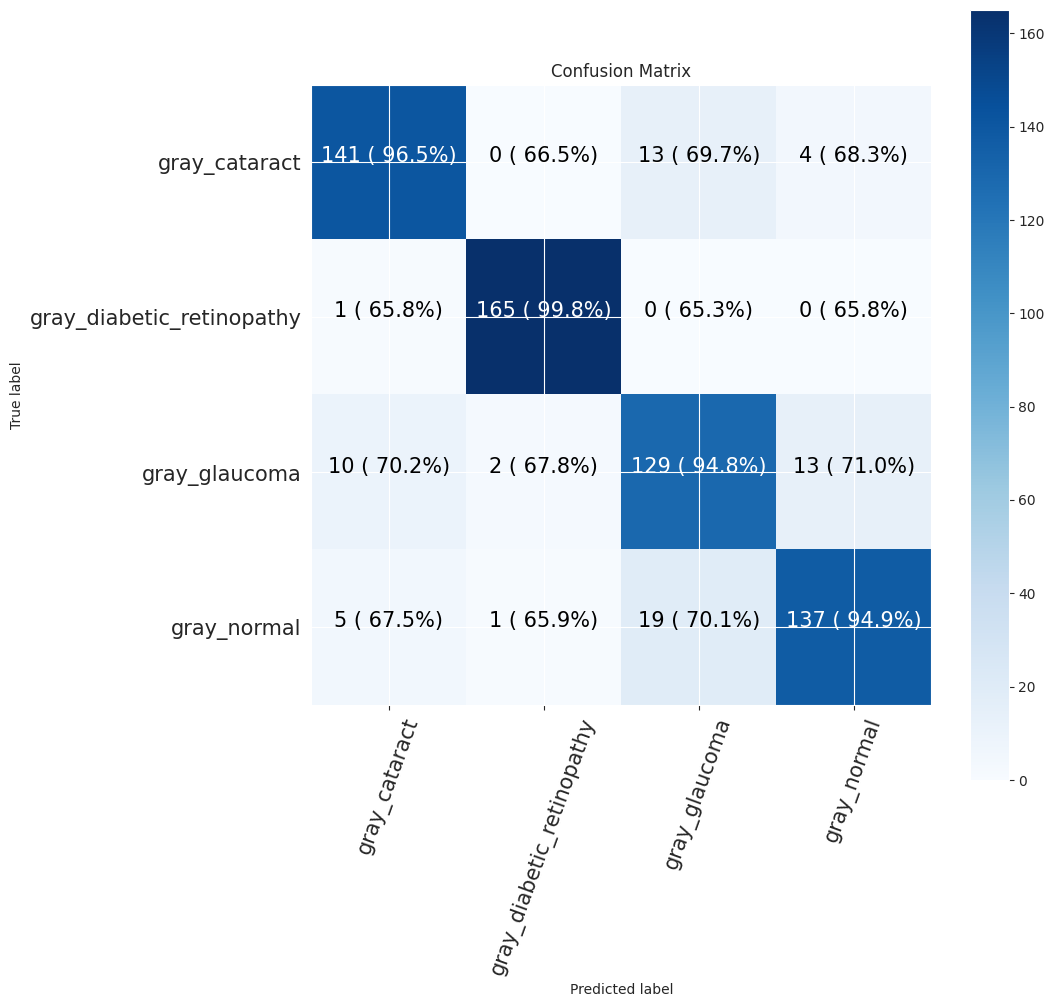

In [159]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


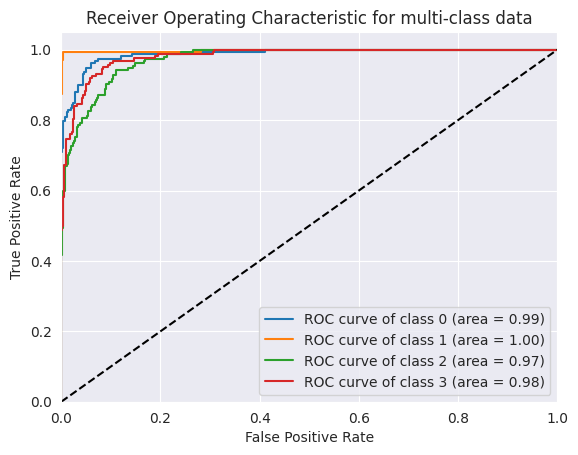

In [160]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [161]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_29 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 4 (GlobalAveragePooling2D)                                      
                                                                 
 dense_43 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_44 (Dense)            (None, 4)                 4100      
                                                          

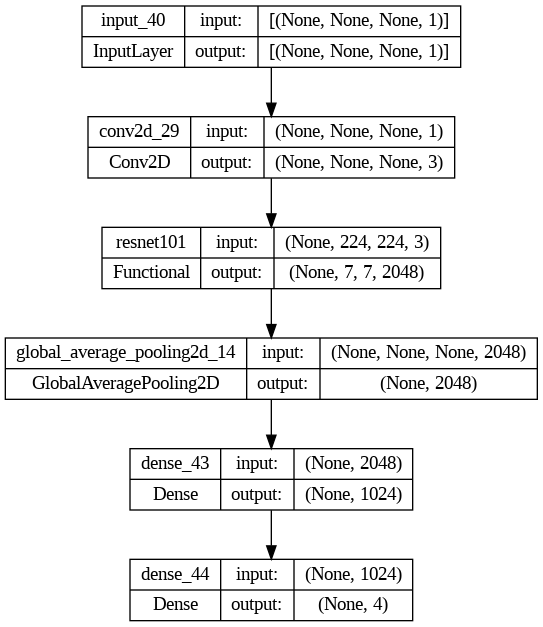

In [162]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [163]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [164]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
106/106 [==============================] - 56s 461ms/step - loss: 0.9006 - accuracy: 0.7217 - val_loss: 0.5749 - val_accuracy: 0.7648 - lr: 0.0010
Epoch 2/20
106/106 [==============================] - 46s 438ms/step - loss: 0.4237 - accuracy: 0.8321 - val_loss: 0.3748 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 3/20
106/106 [==============================] - 47s 439ms/step - loss: 0.3426 - accuracy: 0.8711 - val_loss: 0.3707 - val_accuracy: 0.8452 - lr: 0.0010
Epoch 4/20
106/106 [==============================] - 47s 439ms/step - loss: 0.2967 - accuracy: 0.8873 - val_loss: 0.2948 - val_accuracy: 0.8783 - lr: 0.0010
Epoch 5/20
106/106 [==============================] - 47s 439ms/step - loss: 0.2735 - accuracy: 0.8935 - val_loss: 0.2879 - val_accuracy: 0.8865 - lr: 0.0010
Epoch 6/20
106/106 [==============================] - 47s 440ms/step - loss: 0.2903 - accuracy: 0.8882 - val_loss: 0.3348 - val_accuracy: 0.8641 - lr: 0.0010
Epoch 7/20
106/106 [==============================] 

ResNet101 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 3s 153ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       158
           1       0.98      0.98      0.98       166
           2       0.87      0.75      0.80       154
           3       0.84      0.87      0.85       162

    accuracy                           0.88       640
   macro avg       0.88      0.88      0.88       640
weighted avg       0.88      0.88      0.88       640

Specificity: [0.29292929292929293, 0.3417190775681342, 0.21904761904761905, 0.28256513026052105]
Mean Squared Error: : 0.1104184091091156
The average AUC-ROC is 0.9773952480540528


[0.9721627408993576,
 0.6659619450317125,
 0.7007874015748031,
 0.6800847457627118,
 0.6466809421841542,
 0.9936575052854123,
 0.6732283464566929,
 0.652542372881356,
 0.7109207708779444,
 0.678646934460888,
 0.9232283464566929,
 0.711864406779661,
 0.6702355460385439,
 0.6617336152219874,
 0.702755905511811,
 0.9555084745762712]

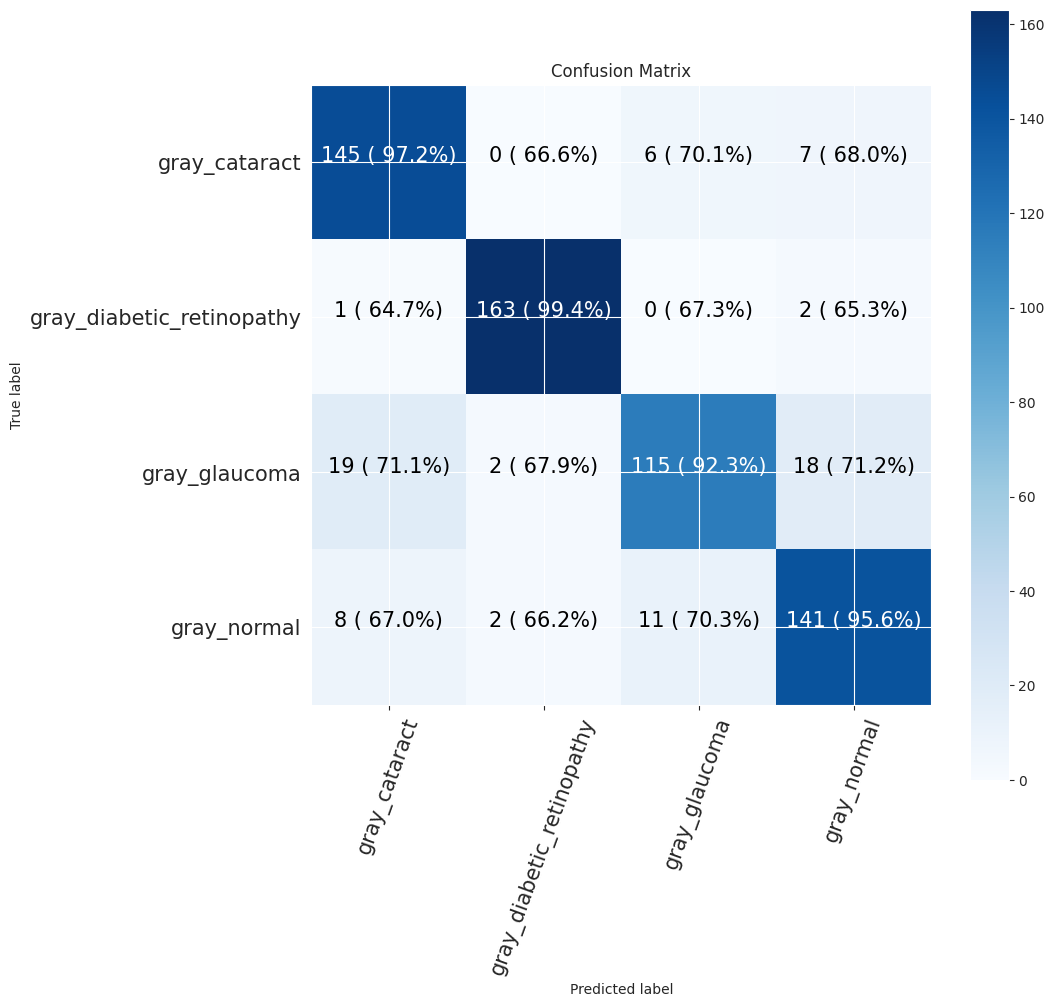

In [165]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


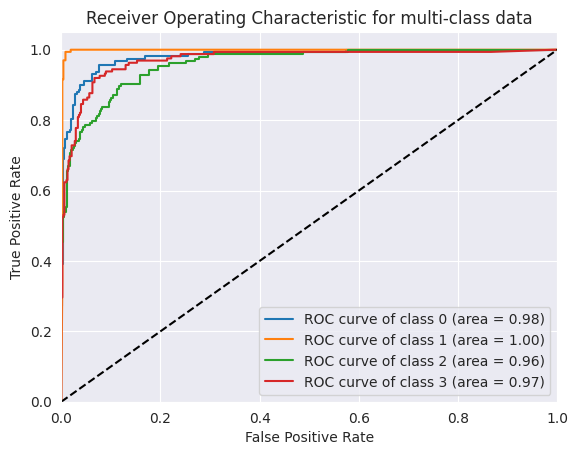

In [166]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 64**

In [167]:
epoch = 20
batchsize = 64

In [168]:
train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_classes = sorted([name for name in os.listdir(train_dir)])
# class_names = train_classes  # Assuming class names are the same across train, test, and val

# Load datasets
train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3389 files belonging to 4 classes.
Found 640 files belonging to 4 classes.
Found 846 files belonging to 4 classes.


In [169]:
class_names = train_data.class_names  # Store class names before transformations

# Apply transformations using map() function
train_data = train_data.map(lambda x, y: (sharpen_image(x), y))
test_data = test_data.map(lambda x, y: (sharpen_image(x), y))
val_data = val_data.map(lambda x, y: (sharpen_image(x), y))


# **EfficientNetV2B3 Model**

In [170]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [171]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
 5 (GlobalAveragePooling2D)                                      
                                                                 
 dense_45 (Dense)            (None, 32)                49184     
                                                          

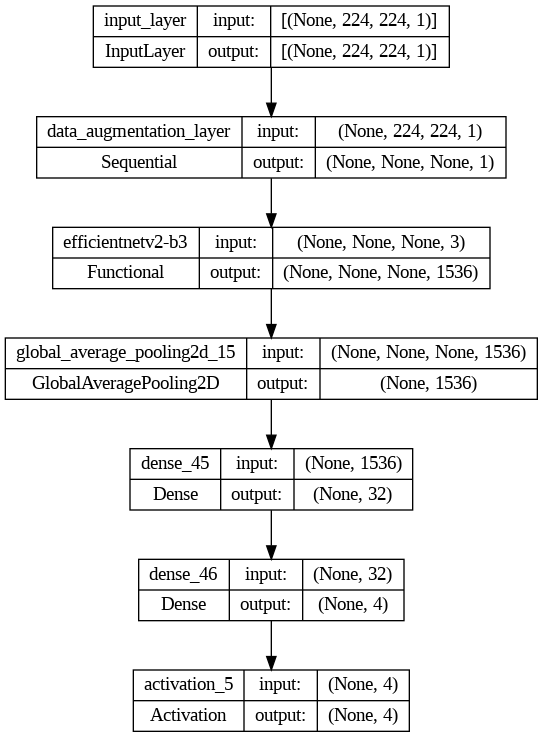

In [172]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [173]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [174]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 25s 260ms/step - loss: 0.7602 - accuracy: 0.6949 - val_loss: 0.6396 - val_accuracy: 0.7411 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 12s 214ms/step - loss: 0.5514 - accuracy: 0.7808 - val_loss: 0.5049 - val_accuracy: 0.8310 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 12s 216ms/step - loss: 0.4906 - accuracy: 0.8129 - val_loss: 0.4989 - val_accuracy: 0.8227 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 12s 220ms/step - loss: 0.4435 - accuracy: 0.8333 - val_loss: 0.4412 - val_accuracy: 0.8546 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 12s 218ms/step - loss: 0.4377 - accuracy: 0.8333 - val_loss: 0.4287 - val_accuracy: 0.8570 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 12s 219ms/step - loss: 0.4203 - accuracy: 0.8421 - val_loss: 0.4157 - val_accuracy: 0.8629 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 12s 217ms/st

EfficientNetV2B3 Evaluation

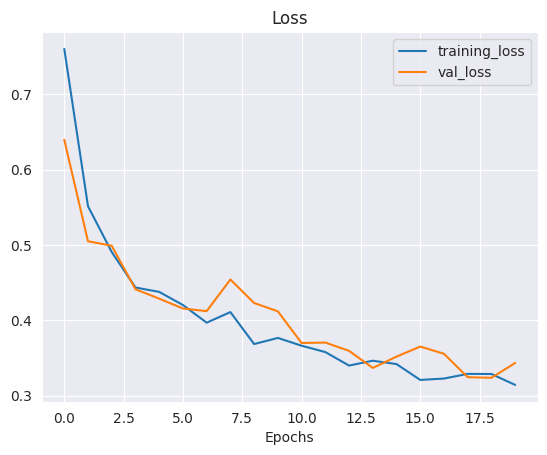

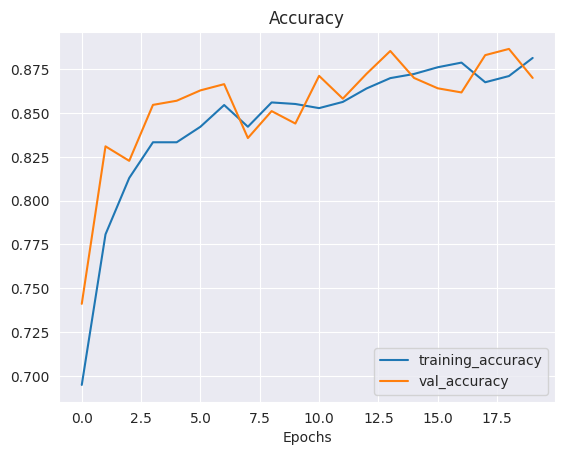

In [175]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 147ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.89       158
           1       0.95      0.97      0.96       166
           2       0.92      0.64      0.75       154
           3       0.79      0.93      0.85       162

    accuracy                           0.87       640
   macro avg       0.88      0.87      0.86       640
weighted avg       0.88      0.87      0.86       640

Specificity: [0.29817444219066935, 0.33611691022964507, 0.18081180811808117, 0.30612244897959184]
Mean Squared Error: : 0.11660834401845932
The average AUC-ROC is 0.974751864025263


[0.9763948497854077,
 0.6645435244161358,
 0.7148217636022514,
 0.66,
 0.6459227467811158,
 0.9893842887473461,
 0.6885553470919324,
 0.64,
 0.7167381974248928,
 0.6794055201698513,
 0.8949343339587242,
 0.7266666666666667,
 0.6609442060085837,
 0.6666666666666666,
 0.701688555347092,
 0.9733333333333334]

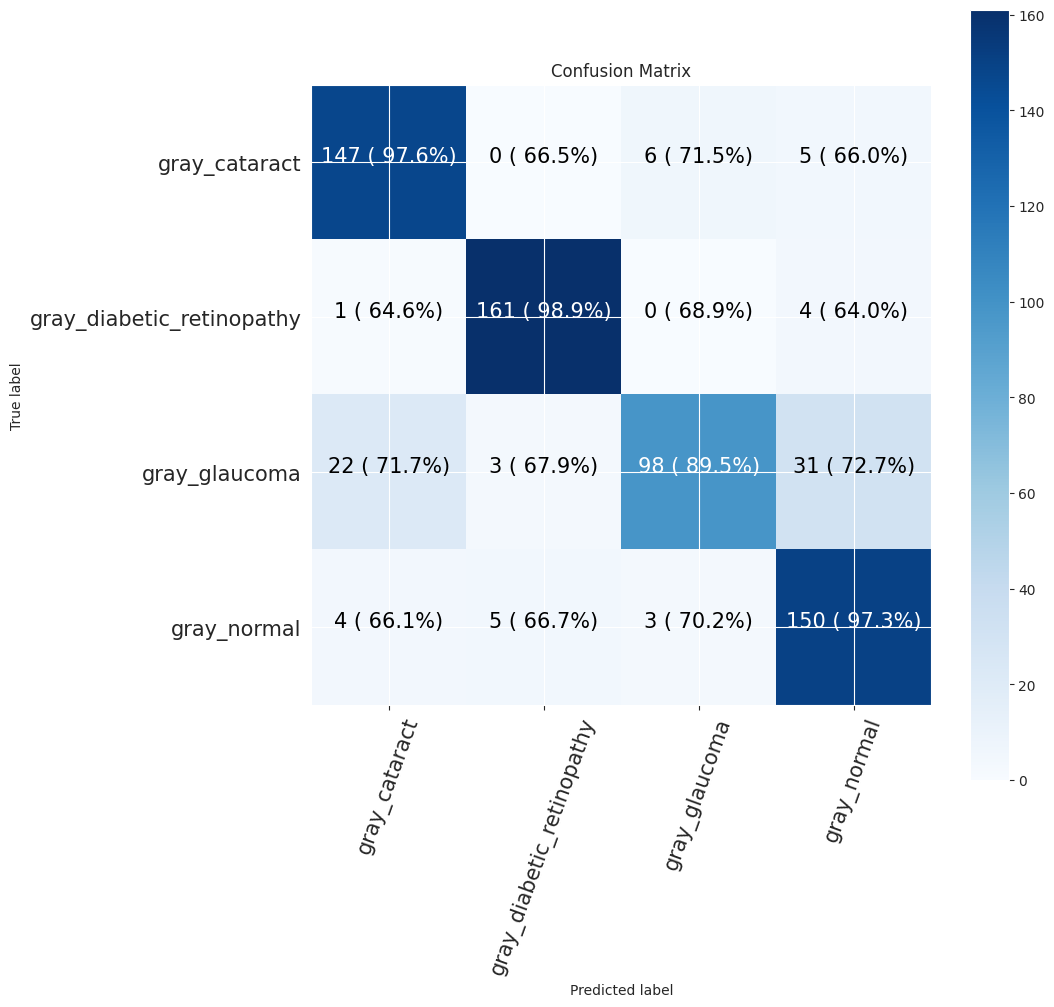

In [176]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


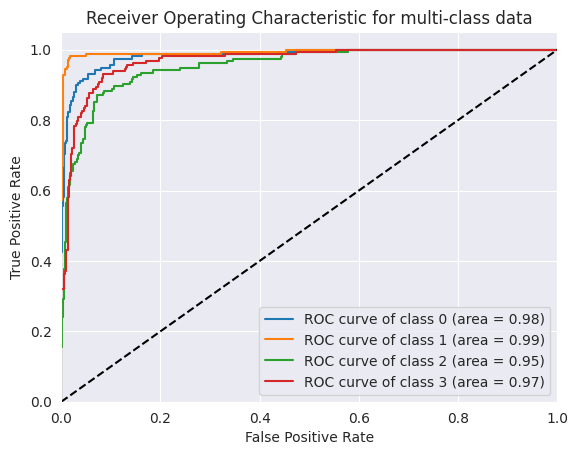

In [177]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [178]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 26, 26, 128)      

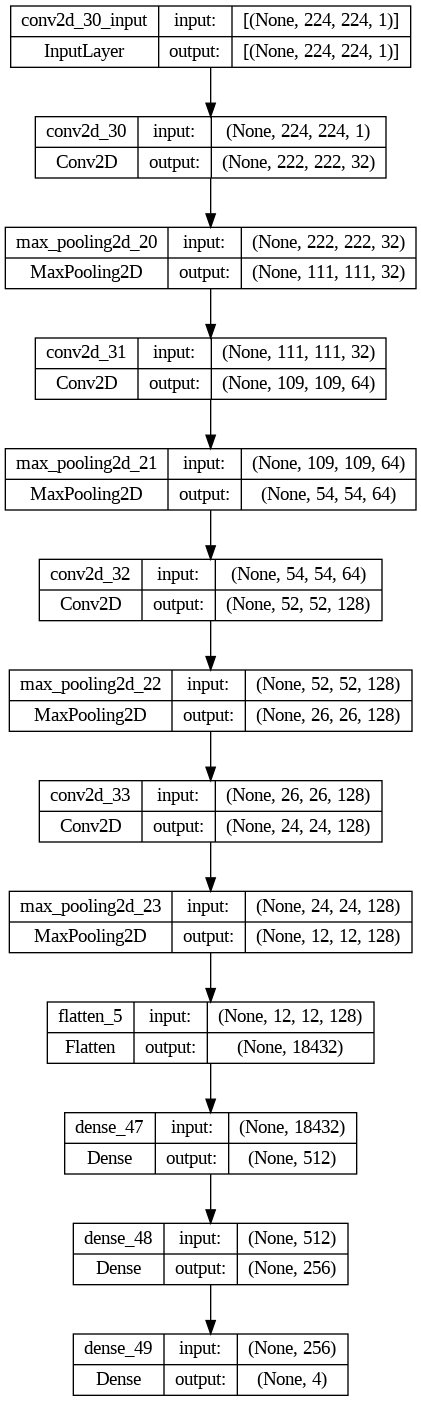

In [179]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [180]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [181]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 6s 73ms/step - loss: 6.9325 - accuracy: 0.4639 - val_loss: 1.0303 - val_accuracy: 0.5934 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 4s 69ms/step - loss: 0.9075 - accuracy: 0.5984 - val_loss: 0.9009 - val_accuracy: 0.5827 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 4s 69ms/step - loss: 0.7947 - accuracy: 0.6173 - val_loss: 0.7456 - val_accuracy: 0.6655 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 4s 69ms/step - loss: 0.7145 - accuracy: 0.6551 - val_loss: 0.7204 - val_accuracy: 0.6572 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 4s 69ms/step - loss: 0.6620 - accuracy: 0.6866 - val_loss: 0.6735 - val_accuracy: 0.7080 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 4s 69ms/step - loss: 0.6393 - accuracy: 0.7014 - val_loss: 0.6692 - val_accuracy: 0.6820 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 4s 69ms/step - loss: 0.6

CNN Evaluation

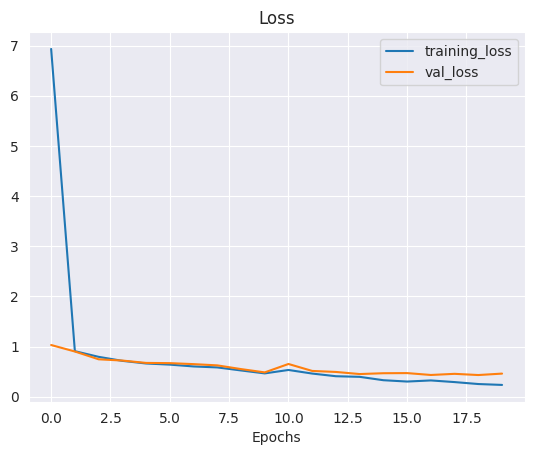

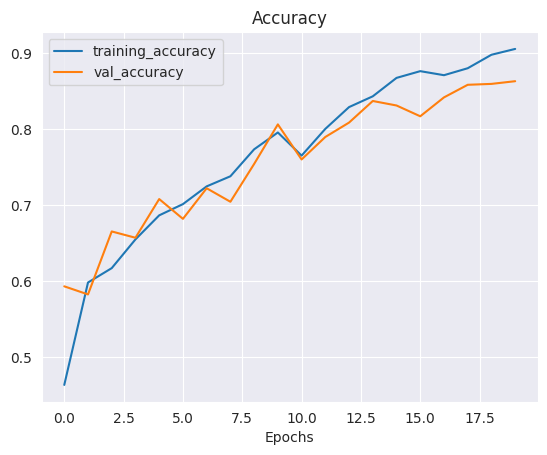

In [182]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 0s 24ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       158
           1       0.99      0.99      0.99       166
           2       0.76      0.62      0.68       154
           3       0.77      0.81      0.79       162

    accuracy                           0.82       640
   macro avg       0.82      0.82      0.81       640
weighted avg       0.82      0.82      0.82       640

Specificity: [0.26232741617357, 0.3445378151260504, 0.1743119266055046, 0.25984251968503935]
Mean Squared Error: : 0.12170484662055969
The average AUC-ROC is 0.9406423297416353


[0.9460043196544277,
 0.6666666666666666,
 0.7145631067961165,
 0.6923076923076923,
 0.6414686825053996,
 0.9957805907172996,
 0.6776699029126214,
 0.6495726495726496,
 0.7408207343412527,
 0.6772151898734177,
 0.8854368932038835,
 0.7222222222222222,
 0.67170626349892,
 0.6603375527426161,
 0.7223300970873786,
 0.9358974358974359]

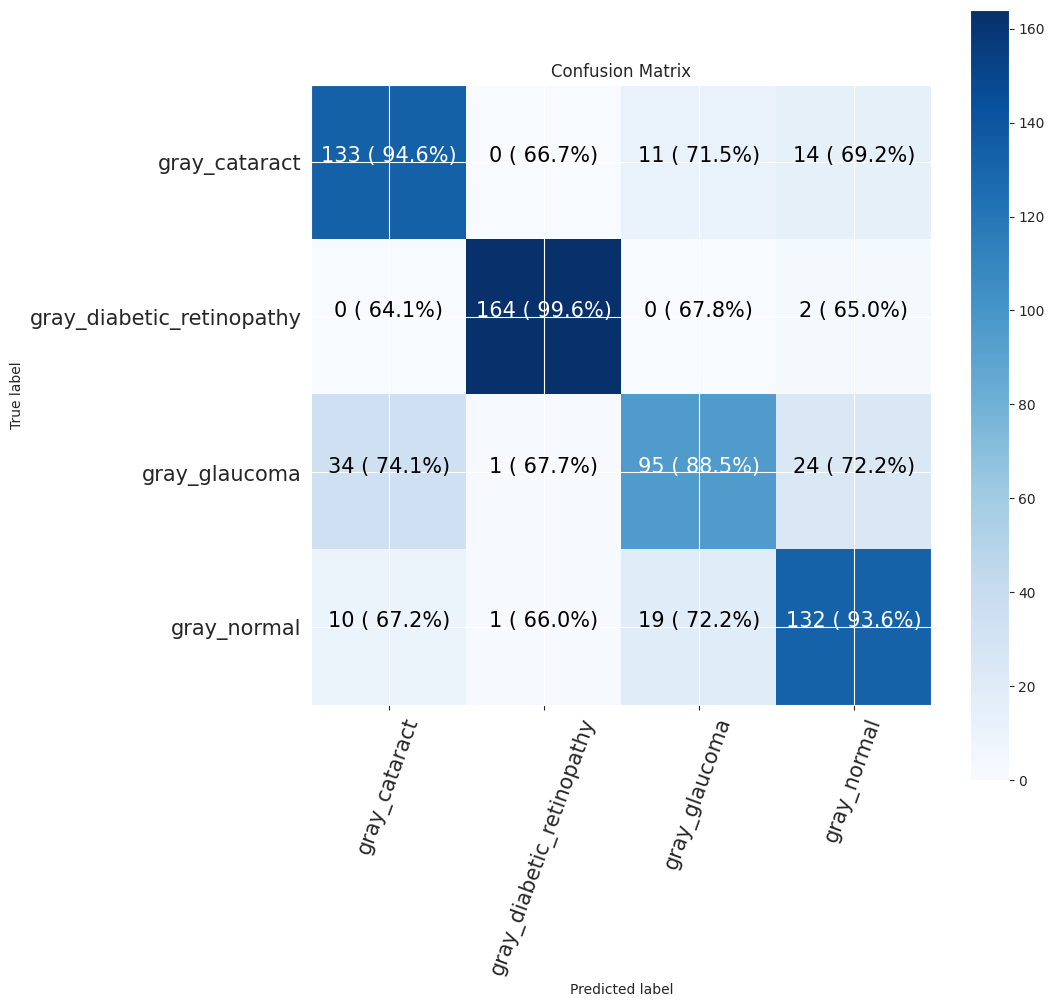

In [183]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


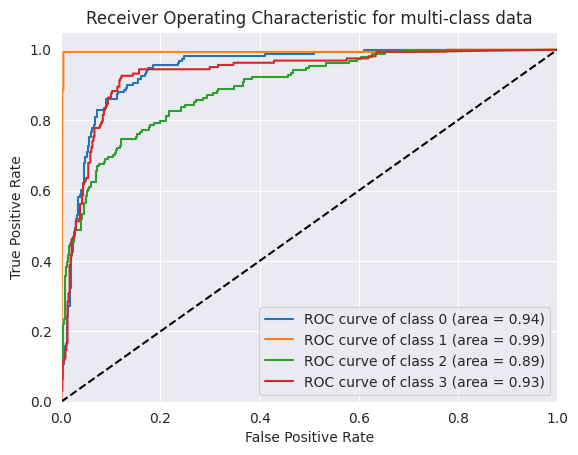

In [184]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [185]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_34 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 6 (GlobalAveragePooling2D)                                      
                                                                 
 dense_50 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_51 (Dense)            (None, 4)                 4100      
                                                          

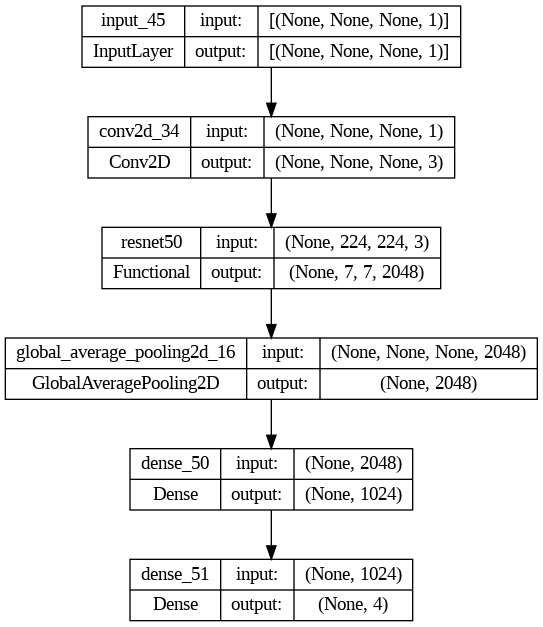

In [186]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [187]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [188]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 33s 540ms/step - loss: 1.0208 - accuracy: 0.7026 - val_loss: 0.5564 - val_accuracy: 0.7754 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 28s 523ms/step - loss: 0.3708 - accuracy: 0.8551 - val_loss: 0.3282 - val_accuracy: 0.8735 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 28s 517ms/step - loss: 0.3040 - accuracy: 0.8849 - val_loss: 0.2798 - val_accuracy: 0.8983 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 28s 518ms/step - loss: 0.2555 - accuracy: 0.8991 - val_loss: 0.2553 - val_accuracy: 0.9031 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 28s 520ms/step - loss: 0.2250 - accuracy: 0.9153 - val_loss: 0.2642 - val_accuracy: 0.8960 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 28s 519ms/step - loss: 0.1844 - accuracy: 0.9366 - val_loss: 0.2794 - val_accuracy: 0.8948 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 28s 519ms/st

ResNet50 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 2s 174ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       158
           1       0.95      0.99      0.97       166
           2       0.80      0.88      0.84       154
           3       0.90      0.76      0.83       162

    accuracy                           0.89       640
   macro avg       0.89      0.89      0.89       640
weighted avg       0.89      0.89      0.89       640

Specificity: [0.3008130081300813, 0.3445378151260504, 0.26732673267326734, 0.2379110251450677]
Mean Squared Error: : 0.10886488854885101
The average AUC-ROC is 0.9836125488113509


[0.9790356394129979,
 0.6623931623931624,
 0.6772823779193206,
 0.6944444444444444,
 0.6540880503144654,
 0.9957264957264957,
 0.6496815286624203,
 0.6706349206349206,
 0.6939203354297694,
 0.6752136752136753,
 0.9596602972399151,
 0.7123015873015873,
 0.6729559748427673,
 0.6666666666666666,
 0.7133757961783439,
 0.9226190476190477]

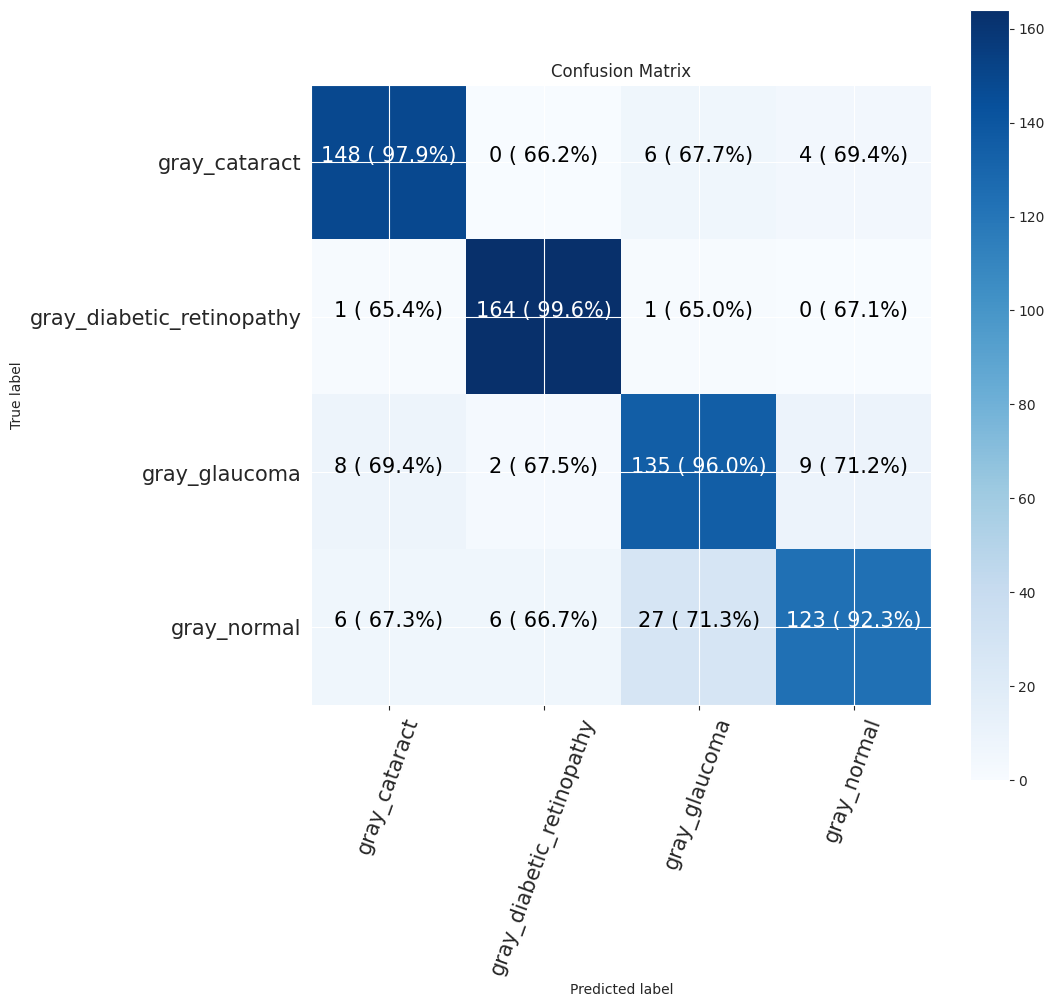

In [189]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


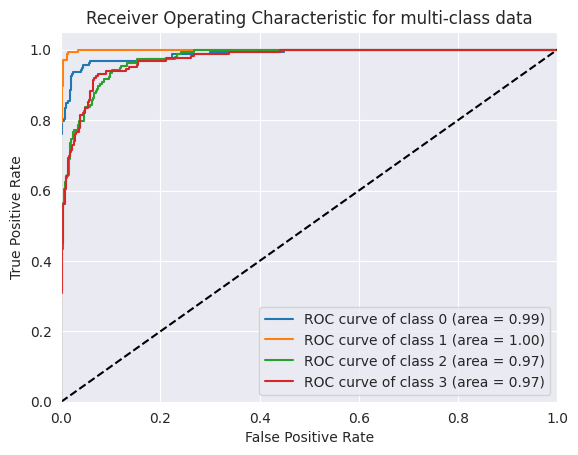

In [190]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [191]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_35 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 7 (GlobalAveragePooling2D)                                      
                                                                 
 dense_52 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_53 (Dense)            (None, 4)                 4100      
                                                          

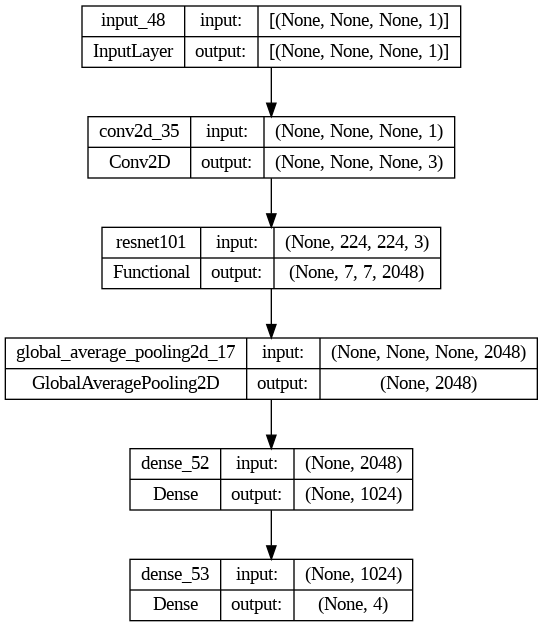

In [192]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [193]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [194]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
53/53 [==============================] - 55s 891ms/step - loss: 0.8451 - accuracy: 0.7232 - val_loss: 0.4162 - val_accuracy: 0.8416 - lr: 0.0010
Epoch 2/20
53/53 [==============================] - 45s 842ms/step - loss: 0.3935 - accuracy: 0.8489 - val_loss: 0.3464 - val_accuracy: 0.8641 - lr: 0.0010
Epoch 3/20
53/53 [==============================] - 45s 847ms/step - loss: 0.3450 - accuracy: 0.8678 - val_loss: 0.3592 - val_accuracy: 0.8522 - lr: 0.0010
Epoch 4/20
53/53 [==============================] - 45s 844ms/step - loss: 0.2968 - accuracy: 0.8885 - val_loss: 0.3280 - val_accuracy: 0.8794 - lr: 0.0010
Epoch 5/20
53/53 [==============================] - 45s 846ms/step - loss: 0.2540 - accuracy: 0.9044 - val_loss: 0.2567 - val_accuracy: 0.8995 - lr: 0.0010
Epoch 6/20
53/53 [==============================] - 45s 846ms/step - loss: 0.2371 - accuracy: 0.9073 - val_loss: 0.2561 - val_accuracy: 0.8948 - lr: 0.0010
Epoch 7/20
53/53 [==============================] - 45s 847ms/st

ResNet101 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 3s 295ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.86       158
           1       0.98      0.99      0.98       166
           2       0.90      0.68      0.77       154
           3       0.84      0.84      0.84       162

    accuracy                           0.87       640
   macro avg       0.88      0.87      0.87       640
weighted avg       0.88      0.87      0.87       640

Specificity: [0.3141683778234086, 0.3445378151260504, 0.19402985074626866, 0.2698412698412698]
Mean Squared Error: : 0.11222933232784271
The average AUC-ROC is 0.9758502594451601


[0.9887387387387387,
 0.6659619450317125,
 0.700381679389313,
 0.6784968684759917,
 0.6283783783783784,
 0.9957716701902748,
 0.683206106870229,
 0.6555323590814196,
 0.7184684684684685,
 0.6765327695560254,
 0.9045801526717557,
 0.7202505219206681,
 0.6644144144144144,
 0.6617336152219874,
 0.7118320610687023,
 0.9457202505219207]

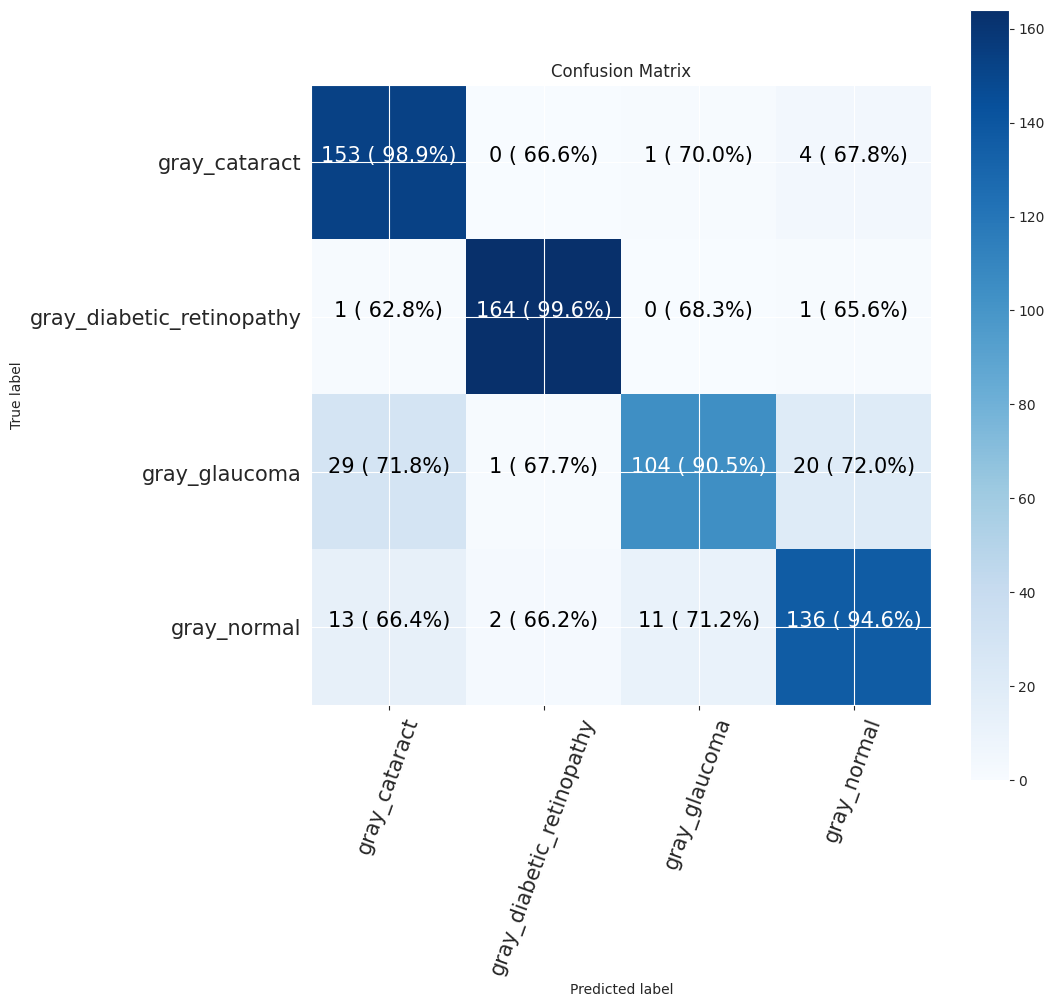

In [195]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


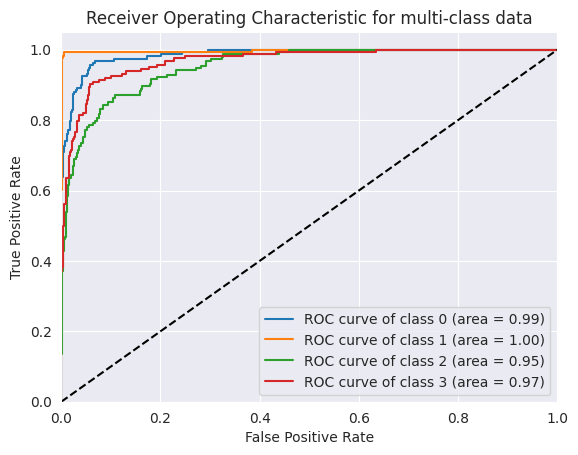

In [196]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()